<a href="https://colab.research.google.com/github/daniyal9538/GeneralProjects/blob/master/SELANI_otto_group_product_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NOTE

For each model i will recompile the train and validation sets from the original data, so that i get a completely random training and validationset for each model. Additionally, as sklearn roc_auc function does not support multiclass classifiers, for each model, i will train the model two times, first as i normally would, and the second time, using the one vs rest classifier function, so that the classifier is able to produce a roc_auc curve
Additionally, for the roc curve, i need to binarize the data

In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.callbacks import TensorBoard
from keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from keras.utils import to_categorical

Using TensorFlow backend.


#Get Data

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


In [0]:
#download and unzip all data 
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle competitions download -c otto-group-product-classification-challenge -p /content
!unzip \*.zip

  0% 0.00/3.34M [00:00<?, ?B/s]
100% 3.34M/3.34M [00:00<00:00, 113MB/s]
  0% 0.00/1.59M [00:00<?, ?B/s]
100% 1.59M/1.59M [00:00<00:00, 108MB/s]
  0% 0.00/3.79M [00:00<?, ?B/s]
100% 3.79M/3.79M [00:00<00:00, 124MB/s]
Archive:  train.csv.zip
  inflating: train.csv               

Archive:  test.csv.zip
  inflating: test.csv                

2 archives were successfully processed.


In [0]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [0]:
df.head()

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,feat_33,feat_34,feat_35,feat_36,feat_37,feat_38,feat_39,...,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,feat_65,feat_66,feat_67,feat_68,feat_69,feat_70,feat_71,feat_72,feat_73,feat_74,feat_75,feat_76,feat_77,feat_78,feat_79,feat_80,feat_81,feat_82,feat_83,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,1,0,4,1,1,0,0,2,0,0,0,0,0,1,0,0,0,0,...,0,0,2,0,0,11,0,1,1,0,1,0,7,0,0,0,1,0,0,0,0,0,0,0,2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,Class_1
1,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,2,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Class_1
2,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,6,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,Class_1
3,4,1,0,0,1,6,1,5,0,0,1,1,0,1,0,0,1,1,0,0,0,0,0,0,7,2,2,0,0,0,58,0,10,0,0,0,0,0,3,0,...,1,0,0,0,0,0,0,0,0,0,2,1,5,0,0,4,0,0,2,1,0,1,0,0,1,1,2,2,0,22,0,1,2,0,0,0,0,0,0,Class_1
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,3,0,0,0,0,0,0,0,4,0,1,0,0,0,1,0,0,0,0,1,0,0,0,Class_1


In [0]:
df_test.head()

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93
0,1,0,0,0,0,0,0,0,0,0,...,0,0,11,1,20,0,0,0,0,0
1,2,2,2,14,16,0,0,0,0,0,...,0,0,0,0,0,4,0,0,2,0
2,3,0,1,12,1,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,1
3,4,0,0,0,1,0,0,0,0,0,...,0,3,1,0,0,0,0,0,0,0
4,5,1,0,0,1,0,0,1,2,0,...,0,0,0,0,0,0,0,9,0,0


#Inspect data

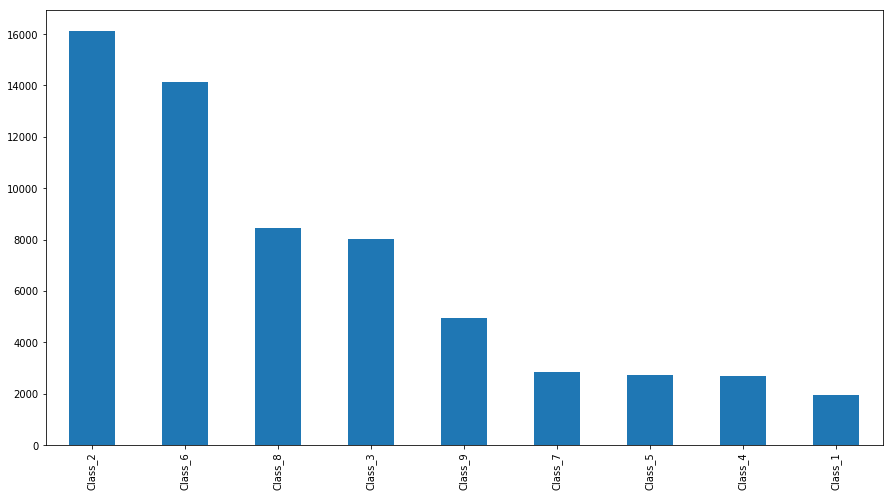

In [0]:
df['target'].value_counts().plot(figsize =(15, 8), kind='bar')

#Convert target variable from string to int

In [0]:
df.loc[df.target == 'Class_1', 'label'] = 1 
df.loc[df.target == 'Class_2', 'label'] = 2 
df.loc[df.target == 'Class_3', 'label'] = 3 
df.loc[df.target == 'Class_4', 'label'] = 4
df.loc[df.target == 'Class_5', 'label'] = 5 
df.loc[df.target == 'Class_6', 'label'] = 6 
df.loc[df.target == 'Class_7', 'label'] = 7 
df.loc[df.target == 'Class_8', 'label'] = 8
df.loc[df.target == 'Class_9', 'label'] = 9
df['label']=df['label'].astype(np.int64)

In [0]:
df=df.reindex(np.random.permutation(df.index))

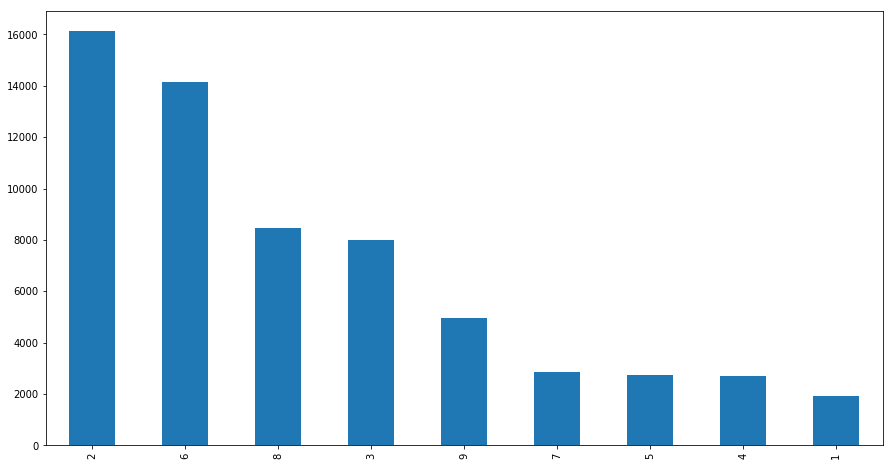

In [0]:
df['label'].value_counts().plot(figsize =(15, 8), kind='bar')

In [0]:
x=df.drop(['target', 'id', 'label'], axis=1)
x.head()

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,feat_33,feat_34,feat_35,feat_36,feat_37,feat_38,feat_39,feat_40,...,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,feat_65,feat_66,feat_67,feat_68,feat_69,feat_70,feat_71,feat_72,feat_73,feat_74,feat_75,feat_76,feat_77,feat_78,feat_79,feat_80,feat_81,feat_82,feat_83,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93
60755,0,0,0,0,0,0,0,6,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,6,1,0,0,0,...,1,0,1,0,0,6,0,0,2,0,2,1,2,4,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
41530,0,1,2,0,0,0,0,0,1,0,3,0,1,0,0,0,0,5,1,0,0,8,0,3,0,6,0,0,1,0,5,0,1,6,0,0,0,2,0,1,...,4,1,0,2,0,0,11,0,0,0,0,0,6,1,1,2,0,0,0,0,0,1,0,0,0,0,3,0,0,1,0,0,0,1,0,0,1,0,2,3
26814,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,17,0,16,0,1,0,0,1
45202,0,0,0,0,0,0,0,0,0,0,8,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
38966,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,4,1,1,0,0,0,1,0,3,0,0,0,0,0,0,0,0,0,1,9,0,0,0,0,0,...,5,0,0,2,0,0,12,0,2,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0


In [0]:
y=df['label']
y.head()

60755    9
41530    6
26814    4
45202    6
38966    6
Name: label, dtype: int64

#Fit MLP

In [0]:
x_train =x.values
y_train = (y.values-1)

In [0]:

y_train = to_categorical(y_train)

In [0]:
model = Sequential()  # a basic feed-forward model
model.add(Dense(500, input_dim=93, activation='relu'))#input layer
#model.add(Dropout(0.5))
#model.add(tf.keras.layers.Dense(100, activation=tf.nn.relu))  # a simple fully-connected layer, 128 units, relu activation
#model.add(Dropout(0.35))
#model.add(tf.keras.layers.Dense(15, activation=tf.nn.relu))  # a simple fully-connected layer, 128 units, relu activation
model.add(Dropout(0.1))
model.add(tf.keras.layers.Dense(9,  activation=tf.nn.softmax))


model.compile(optimizer='adam',  # Good default optimizer to start with
              loss='categorical_crossentropy',  # how will we calculate our "error." Neural network aims to minimize loss.
              metrics=[metrics.mae, metrics.categorical_accuracy])  # what to track
tensorboard = TensorBoard(log_dir="logs/{}".format('NAME'))

history = model.fit(x_train, y_train, epochs=30, validation_split = 0.3, callbacks=[tensorboard])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 43314 samples, validate on 18564 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
43314/43314 [==============================] - 6s 144us/sample - loss: 0.6643 - mean_absolute_error: 0.0755 - categorical_accuracy: 0.7509 - val_loss: 0.6042 - val_mean_absolute_error: 0.0652 - val_categorical_accuracy: 0.7674
Epoch 2/30
43314/43314 [==============================] - 5s 120us/sample - loss: 0.5560 - mean_absolute_error: 0.0655 - categorical_accuracy: 0.7828 - val_loss: 0.5696 - val_mean_absolute_error: 0.0633 - val_categorical_accuracy: 0.7823
Epoch 3/30
43314/43314 [==============================] - 5s 121us/sample - loss: 0.5222 - mean_absolute_error: 0.0621 - categorical_accuracy: 0.7954 - val_loss: 0.5582 - val_mean_absolute_error: 0.0630 - val_categorical_accuracy: 0.7825
E

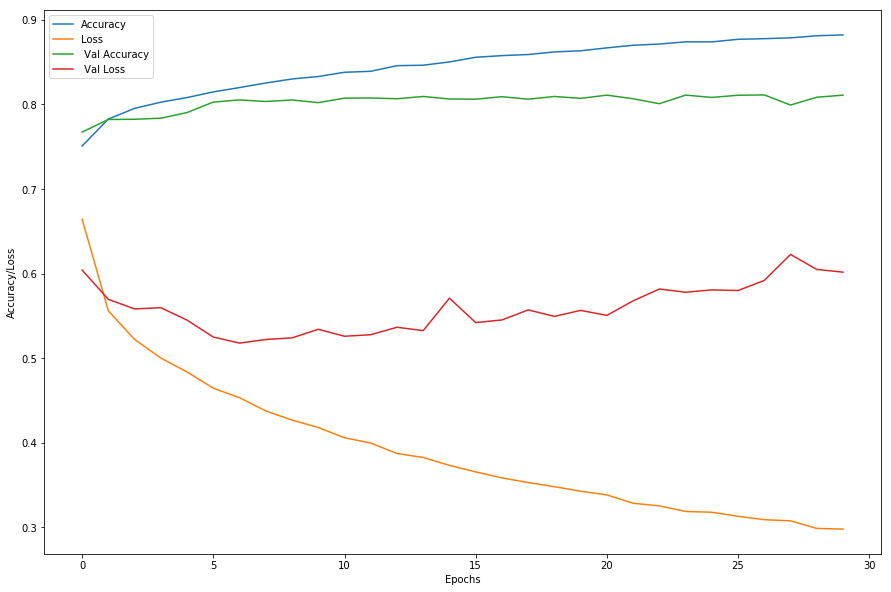

In [0]:
plt.figure(figsize = (15,10))
plt.plot(range(30), history.history['categorical_accuracy'], label = 'Accuracy')
plt.plot(range(30), history.history['loss'], label = 'Loss')
plt.plot(range(30), history.history['val_categorical_accuracy'], label = ' Val Accuracy')
plt.plot(range(30), history.history['val_loss'], label = ' Val Loss')
#ax1.set_xticks(np.arange(0, 31, 5))
plt.xlabel("Epochs")
plt.ylabel('Accuracy/Loss')

plt.legend(loc = "best")

According to the findings in the following paper http://ceur-ws.org/Vol-1734/fmt-proceedings-2016-paper2.pdf, shallow and wide networks work best for categorical data for classification using MLPs. A low drop out rate and a single hidden layer with width > 400 nodes yielded the best results.However, adding nodes more than 400 yielded greatly diminished returns. Model overfits, as val_accuracy stagnates while accuracy increases. Increasing drop out reduces over all accuracy and does not help over fitting. Over fitting could be helped by more data 

##MLP ROC

Could not figure out how to build roc curve with the keras api

# KNN

In [0]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from IPython.display import clear_output
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from time import time


In [0]:
X =x.values
Y = (y.values-1)
Y = to_categorical(Y)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 0, test_size= 0.3) 

In [0]:
knn = KNN(n_neighbors = int(5))
now = time()
knn.fit(X_train, y_train)
score_knn = knn.score(X_test, y_test)
clear_output()
print('Score and time taken: ', score_knn, time()-now)

Score and time taken:  0.7480607627666451 118.09942650794983


In [0]:
pred = knn.predict(X_test)


In [0]:

auc = roc_auc_score(y_test, pred)
print("AUC:", auc)

AUC: 0.8260706227056143


##KNN ROC

In [0]:
Y = label_binarize(Y, classes=[0,1,2, 3, 4, 5, 6, 7, 8])
n_classes = 9

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# classifier
clf = OneVsRestClassifier(KNN( n_neighbors = int(5)))
y_score = clf.fit(X_train, y_train)

In [0]:
score_clf = clf.score(X_test, y_test)

print('Score: ', score_clf)

Score:  0.7450048971596474


In [0]:
probs = clf.predict_proba(X_test)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


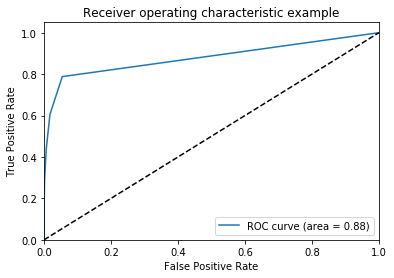

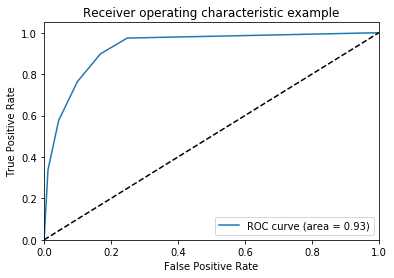

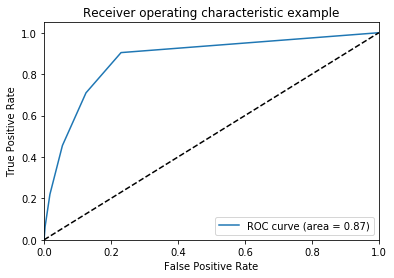

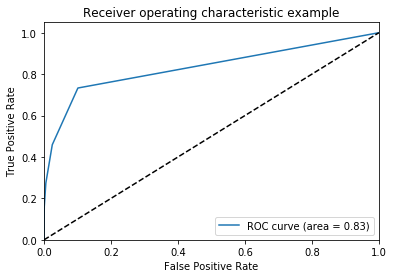

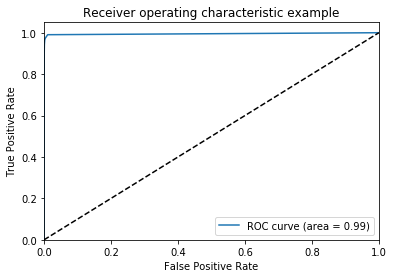

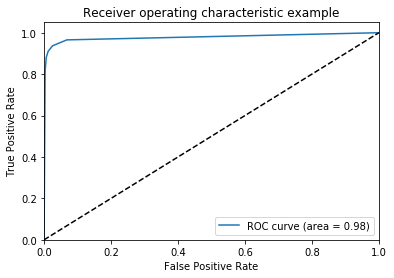

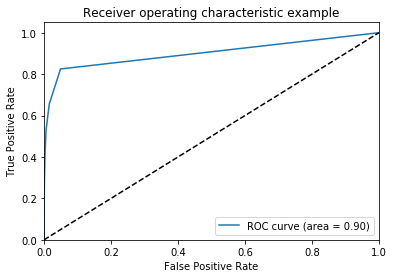

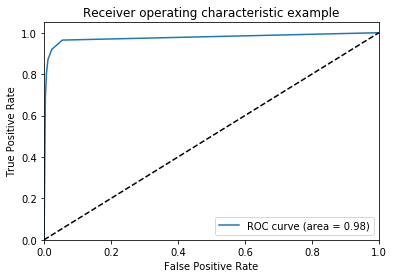

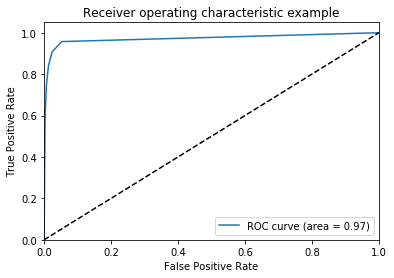

In [0]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], probs[:, i])
    print(type(fpr[i]), type(tpr[i]))
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

#Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier as RF

In [0]:
X =x.values
Y = (y.values-1)
Y = to_categorical(Y)
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 10, test_size= 0.3) 

In [0]:
rf = RF(n_estimators=200, max_depth=35, random_state=0)
now = time()
rf.fit(X_train, y_train)
score_rf = rf.score(X_test, y_test)
clear_output()
'Score, time taken, feature importance',score_rf, time()-now, rf.feature_importances_

('Score, time taken, feature importance',
 0.6829347123464771,
 58.96668863296509,
 array([0.00670545, 0.00380884, 0.0150075 , 0.01096664, 0.00187208,
        0.00080577, 0.00327634, 0.01455766, 0.01247781, 0.0040896 ,
        0.04345252, 0.00230429, 0.0059464 , 0.03057004, 0.02443508,
        0.0110148 , 0.00924766, 0.00599626, 0.0042492 , 0.00697762,
        0.00327635, 0.00627974, 0.003206  , 0.01832094, 0.02621453,
        0.02647156, 0.01148969, 0.00403213, 0.00459549, 0.00945606,
        0.00190791, 0.01279924, 0.01014014, 0.04758699, 0.00804728,
        0.01938944, 0.00584465, 0.00746075, 0.01290036, 0.02836333,
        0.00728816, 0.02359973, 0.01292348, 0.00534778, 0.00422403,
        0.00938167, 0.00826171, 0.01752702, 0.00325302, 0.00765348,
        0.00108344, 0.0025737 , 0.00964352, 0.00985809, 0.00518915,
        0.00657616, 0.01209393, 0.00730557, 0.00933125, 0.04117208,
        0.00926694, 0.01920191, 0.00263216, 0.01367754, 0.00330756,
        0.00701136, 0.02346829, 0

In [0]:
pred = rf.predict(X_test)

auc = roc_auc_score(y_test, pred)
print("AUC:", auc)

AUC: 0.7764675422043693


##Random Forest ROC

In [0]:
Y = label_binarize(Y, classes=[0,1,2, 3, 4, 5, 6, 7, 8])
n_classes = 9

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=10)

# classifier
clf = OneVsRestClassifier(RF( n_estimators=200, max_depth=35, random_state=0))
clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=35,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=200,
                                                     n_jobs=None,
                                                

In [0]:
score_clf = clf.score(X_test, y_test)

print('Score: ', score_clf)

Score:  0.7033505709976299


In [0]:
probs = clf.predict_proba(X_test)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


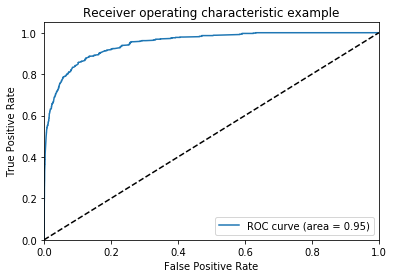

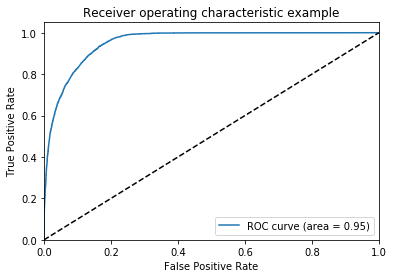

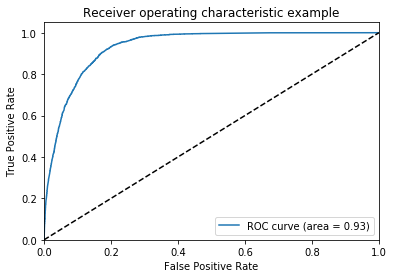

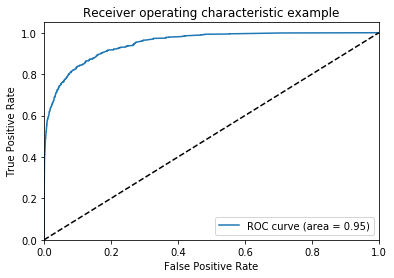

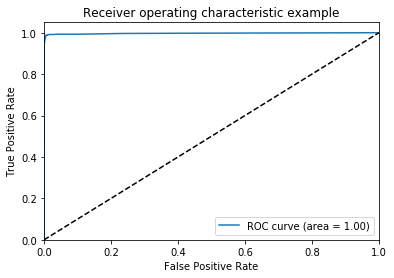

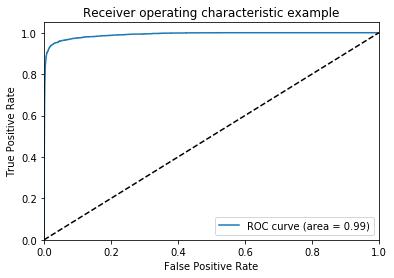

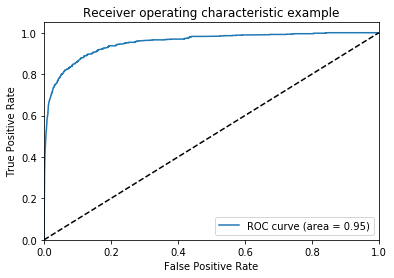

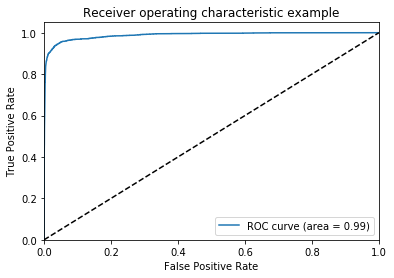

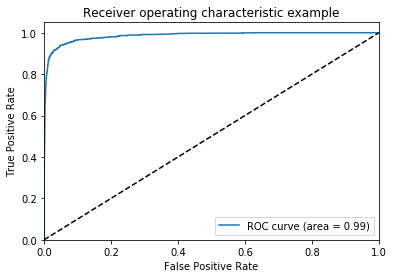

In [0]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], probs[:, i])
    print(type(fpr[i]), type(tpr[i]))
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

#SVM

In [0]:
from sklearn.svm import SVC as svc

In [0]:
X =x.values
Y = (y.values-1)
#Y = to_categorical(Y)
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 100, test_size= 0.3) 

In [46]:
X_train.shape, y_train.shape

((43314, 93), (43314,))

In [48]:
clf=svc()
svm = clf.fit(X_train, y_train)
#clear_output()
score_svm=svm.score(X_test, y_test)
'Score: ', score_svm

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


('Score: ', 0.7821051497522086)

##SVM ROC

In [0]:
Y = label_binarize(Y, classes=[0,1,2, 3, 4, 5, 6, 7, 8])
n_classes = 9

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# classifier
clf = OneVsRestClassifier(svc(probability=True))
y_score = clf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [0]:
score_clf = clf.score(X_test, y_test)

print('Score: ', score_clf)

In [0]:
probs = clf.predict_proba(X_test)

In [0]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], probs[:, i])
    print(type(fpr[i]), type(tpr[i]))
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

#XGBOOST

In [0]:
!pip install xgboost


In [0]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer

In [0]:

X =x.values
Y = (y.values-1)

Y = to_categorical(Y)
Y = label_binarize(Y, classes=[0,1,2, 3, 4, 5, 6, 7, 8])
n_classes = 9
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 110, test_size= 0.3) 

In [0]:
xgb = OneVsRestClassifier(XGBClassifier(n_jobs=-1, max_depth=4))
mlb = MultiLabelBinarizer()
#y_train_transformed = mlb.fit_transform(y_train)

xgb.fit(X_train, y_train)

OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bytree=1, gamma=0,
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=4, min_child_weight=1,
                                            missing=None, n_estimators=100,
                                            n_jobs=-1, nthread=None,
                                            objective='binary:logistic',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=1,
                                            seed=None, silent=True,
                                            subsample=1),
                    n_jobs=None)

In [0]:
# make predictions for test data
y_pred = xgb.predict(X_test)

In [0]:

accuracy = accuracy_score(y_test, y_pred)
'Score: ', accuracy

('Score: ', 0.6620879120879121)

##XGBOOST ROC

In [0]:
probs = xgb.predict_proba(X_test)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


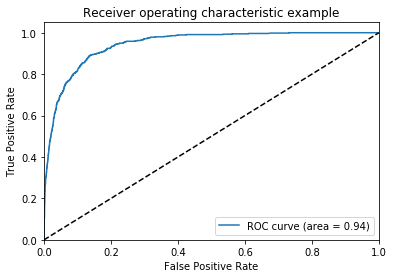

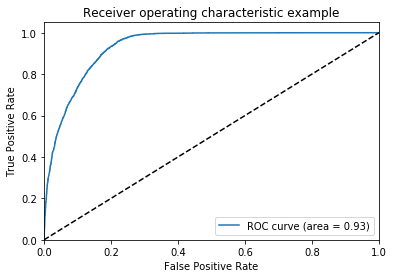

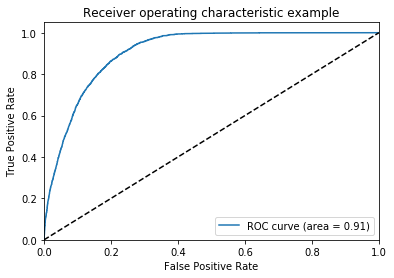

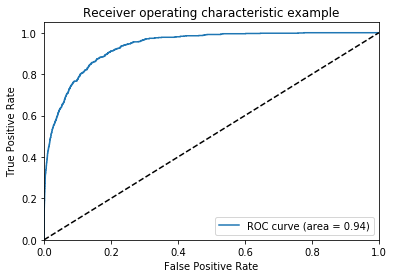

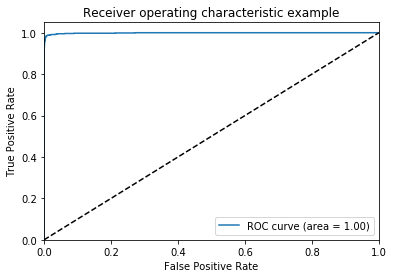

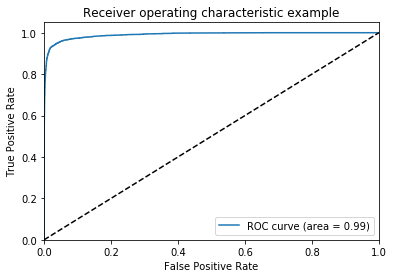

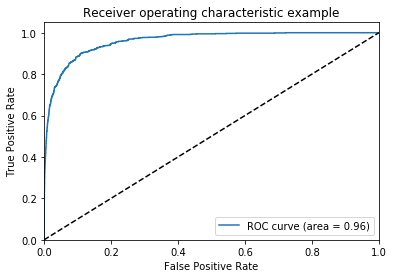

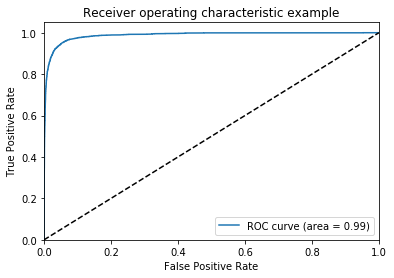

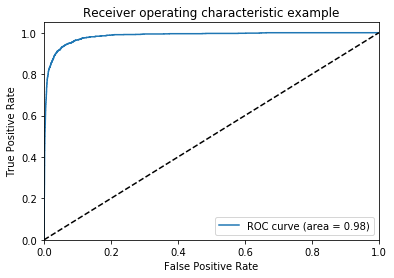

In [0]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], probs[:, i])
    print(type(fpr[i]), type(tpr[i]))
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

#Comparision

Validation Accuracy scores:

MLP: 81%

KNN: 75%

Random Forest: 68%

SVM: 78%

XGBOOST: 66%

Models would perform better with feature engineering. It would be good to use random forests for feature importance ranking and modifying the data accordingly. Shallow mlp performs best as the model is complex enough to deal with the dataset without having any feature engineering done on it.
XGBOOST and Random Forests perform suprisingly poorly,could be resolved by doing grid search on parameters (Hyper paramter turning)
